<a href="https://colab.research.google.com/github/SLCFLAB/Data-Science-Python/blob/main/Day%2012/12_4_stock_price_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction with RNN

For this part of today's session, you will practice how to predict future stock prices using vanilla RNN. This is a simple example and it's difficult to say that quant traders use this kind of model to generate signal. But it's important to understand the basic system so please carefully read along the code.

I refer to this blog post: https://data-science-hi.tistory.com/190

In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

     |████████████████████████████████| 109 kB 5.0 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler

## Get financial data with pandas datareader

**pandas-datareader** is widely used to get daily transaction data. I will show you how to use it. And with this library, we will download 'Samsung Electronics' stock prices.

In [ ]:
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2022,1,2)

In [ ]:
apple = pdr.DataReader('AAPL', 'yahoo', start, end)

In [ ]:
apple

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.575912
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.643498
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.783868
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.917508
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.897016
...,...,...,...,...,...,...
2021-12-27,180.419998,177.070007,177.089996,180.330002,74919600.0,180.100540
2021-12-28,181.330002,178.529999,180.160004,179.289993,79144300.0,179.061859
2021-12-29,180.630005,178.139999,179.330002,179.380005,62348900.0,179.151749


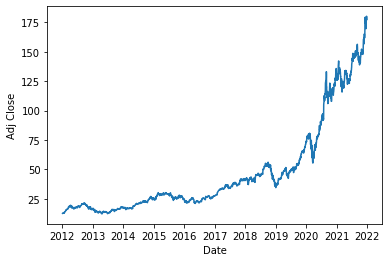

In [ ]:
sns.lineplot(data=apple.iloc[:,-1])
plt.show()

In [ ]:
kospi = pdr.DataReader('KOSPI', 'naver', start, end)

In [ ]:
kospi

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-02,1831.69,1837.81,1814.55,1826.37,323358
2012-01-03,1846.56,1875.41,1846.56,1875.41,443474
2012-01-04,1883.48,1884.69,1866.22,1866.22,494500
2012-01-05,1869.42,1875.97,1860.57,1863.74,533768
2012-01-06,1867.12,1867.12,1824.29,1843.14,472680
...,...,...,...,...,...
2021-12-24,3009.48,3025.77,3009.48,3012.43,537548
2021-12-27,3013.94,3017.31,2999.3,2999.55,475363
2021-12-28,3006.77,3020.29,2991.55,3020.24,607046


In [ ]:
kospi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2463 entries, 2012-01-02 to 2021-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Open    2463 non-null   object
 1   High    2463 non-null   object
 2   Low     2463 non-null   object
 3   Close   2463 non-null   object
 4   Volume  2463 non-null   object
dtypes: object(5)
memory usage: 115.5+ KB


In [ ]:
kospi = kospi.astype(np.float64)

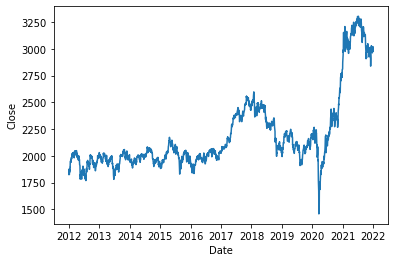

In [ ]:
sns.lineplot(data = kospi.iloc[:,-2])
plt.show()

In [ ]:
samsung = pdr.DataReader('005930.KS', 'yahoo', start, end)

In [ ]:
samsung

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-02,21600.0,21300.0,21400.0,21600.0,13151350.0,17500.316406
2012-01-03,22100.0,21840.0,21860.0,22100.0,16927750.0,17905.414062
2012-01-04,22200.0,21500.0,22100.0,21600.0,17103700.0,17500.316406
2012-01-05,21580.0,21100.0,21460.0,21100.0,17298400.0,17095.216797
2012-01-06,21320.0,20600.0,21120.0,20800.0,18816250.0,16852.156250
...,...,...,...,...,...,...
2021-12-24,80800.0,80200.0,80200.0,80500.0,12086380.0,79725.992188
2021-12-27,80600.0,79800.0,80600.0,80200.0,10783368.0,79428.882812
2021-12-28,80400.0,79700.0,80200.0,80300.0,18226325.0,79527.921875


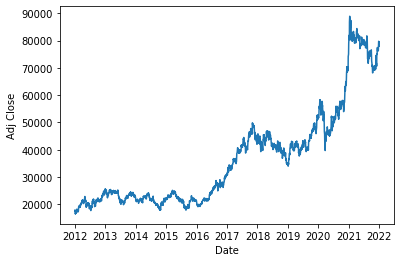

In [ ]:
sns.lineplot(data = samsung.iloc[:,-1])
plt.show()

In [ ]:
samsung.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2462 entries, 2012-01-02 to 2021-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2462 non-null   float64
 1   Low        2462 non-null   float64
 2   Open       2462 non-null   float64
 3   Close      2462 non-null   float64
 4   Volume     2462 non-null   float64
 5   Adj Close  2462 non-null   float64
dtypes: float64(6)
memory usage: 134.6 KB


## Price Prediction

In [ ]:
scaler = MinMaxScaler()

In [ ]:
samsung['High, Low, Open, Close, Volume'.split(', ')] = scaler.fit_transform(samsung['High, Low, Open, Close, Volume'.split(', ')])

In [ ]:
samsung.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-02,0.014675,0.015589,0.015433,0.018110,0.145631,17500.316406
2012-01-03,0.021226,0.023383,0.022006,0.025184,0.187448,17905.414062
2012-01-04,0.022537,0.018476,0.025436,0.018110,0.189397,17500.316406
2012-01-05,0.014413,0.012702,0.016290,0.011036,0.191553,17095.216797
2012-01-06,0.011006,0.005485,0.011432,0.006791,0.208361,16852.156250


In [ ]:
samsung.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2462 entries, 2012-01-02 to 2021-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2462 non-null   float64
 1   Low        2462 non-null   float64
 2   Open       2462 non-null   float64
 3   Close      2462 non-null   float64
 4   Volume     2462 non-null   float64
 5   Adj Close  2462 non-null   float64
dtypes: float64(6)
memory usage: 134.6 KB


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # device
print(f"{device} is avaiable")
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))

cuda:0 is avaiable
Tesla K80


In [ ]:
df = samsung.copy()

In [ ]:
X = df['Open, High, Low, Volume'.split(', ')].values
y = df['Close'].values

In [ ]:
def seq_data(x, y, sequence_length):
  
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[i: i+sequence_length])
    y_seq.append(y[i+sequence_length])

  x_seq = np.array(x_seq)
  y_seq = np.array(y_seq)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1])

In [ ]:
split_size = 0.8
split_index = int(len(X) * split_size)
print(split_index)

1969


In [ ]:
sequence_length = 5

In [ ]:
x_seq, y_seq = seq_data(X, y, sequence_length)

x_train_seq = x_seq[:split_index]
y_train_seq = y_seq[:split_index]
x_test_seq = x_seq[split_index:]
y_test_seq = y_seq[split_index:]
print(x_train_seq.shape, y_train_seq.shape)
print(x_test_seq.shape, y_test_seq.shape)

torch.Size([1969, 5, 4]) torch.Size([1969, 1])
torch.Size([488, 5, 4]) torch.Size([488, 1])


In [ ]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [ ]:
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [ ]:
class VanillaRNN(nn.Module):

  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid())

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state 설정하기.
    out, _ = self.rnn(x, h0) # out: RNN의 마지막 레이어로부터 나온 output feature 를 반환한다. hn: hidden state를 반환한다.
    out = out.reshape(out.shape[0], -1) # many to many 전략
    out = self.fc(out)
    return out
    
model = VanillaRNN(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)


In [ ]:
criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 200
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
loss_graph = [] # 그래프 그릴 목적인 loss.
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0.0

  for data in train_loader:

    seq, target = data # 배치 데이터.
    out = model(seq)   # 모델에 넣고,
    loss = criterion(out, target) # output 가지고 loss 구하고,

    optimizer.zero_grad() # 
    loss.backward() # loss가 최소가 되게하는 
    optimizer.step() # 가중치 업데이트 해주고,
    running_loss += loss.item() # 한 배치의 loss 더해주고,

  loss_graph.append(running_loss / n) # 한 epoch에 모든 배치들에 대한 평균 loss 리스트에 담고,
  if epoch % 20 == 0:
    print('[epoch: %d] loss: %.4f'%(epoch, running_loss/n))

[epoch: 0] loss: 0.0459
[epoch: 20] loss: 0.0005
[epoch: 40] loss: 0.0003
[epoch: 60] loss: 0.0003
[epoch: 80] loss: 0.0002
[epoch: 100] loss: 0.0002
[epoch: 120] loss: 0.0002
[epoch: 140] loss: 0.0001
[epoch: 160] loss: 0.0001
[epoch: 180] loss: 0.0001


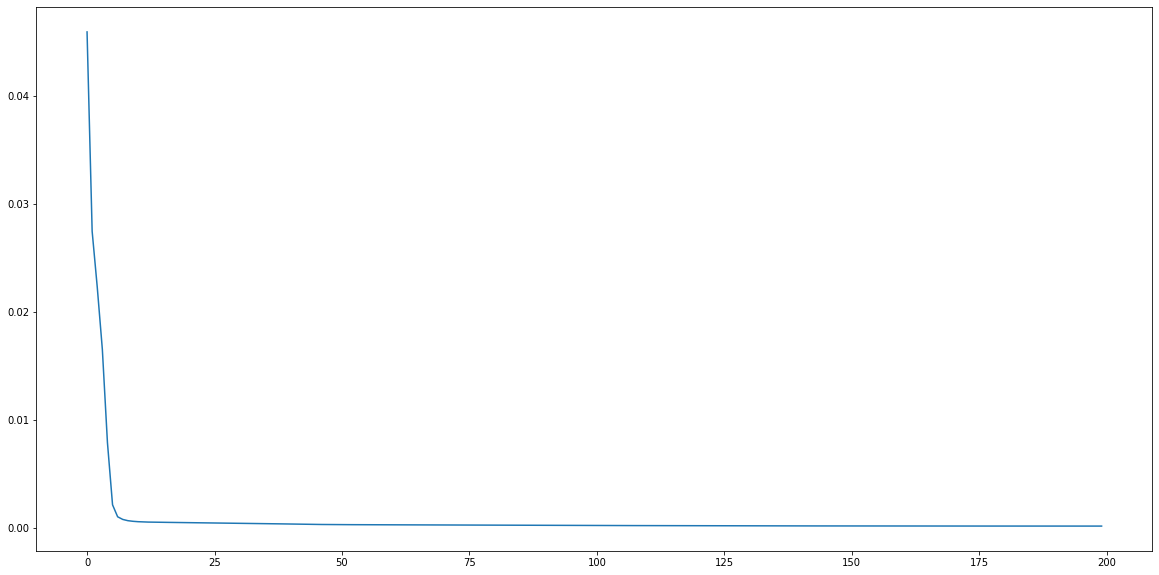

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

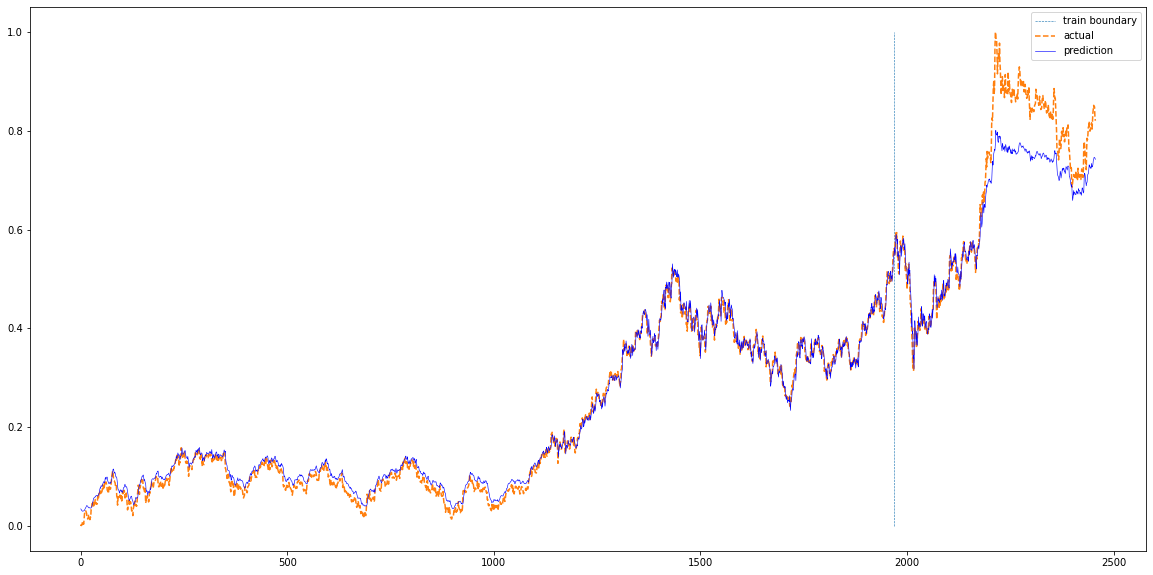

In [ ]:
def plotting(train_loader, test_loader, actual):
  with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in train_loader:
      seq, target = data
      out = model(seq)
      train_pred += out.cpu().numpy().tolist()

    for data in test_loader:
      seq, target = data
      out = model(seq)
      test_pred += out.cpu().numpy().tolist()
      
  total = train_pred + test_pred
  plt.figure(figsize=(20,10))
  plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
  plt.plot(actual, '--')
  plt.plot(total, 'b', linewidth=0.6)

  plt.legend(['train boundary', 'actual', 'prediction'])
  plt.show()

plotting(train_loader, test_loader, df['Close'].iloc[sequence_length:].values)